In [54]:
import os
import math
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import regularizers
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add

# Resnet Architecture

In [55]:
class ResnetBlock(Model):
    def __init__(self, channels: int, down_sample=False):
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            self.res_conv = Conv2D(self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

# Model Wrapper

In [56]:
class ModelWrapper:
    def __init__(self, model, batch_size):
        self.model = model
        self.batch_size = batch_size

    def train(self, train_data, validation_data, callbacks, epochs=50):
        history = self.model.fit(
            train_data,
            steps_per_epoch=train_data.samples // self.batch_size,
            validation_data=validation_data,
            validation_steps=validation_data.samples // self.batch_size,
            callbacks = callbacks,
            epochs=epochs)

        return history
    
    def compile(self,optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy']):
        self.model.compile(optimizer = optimizer,loss=loss, metrics=metrics)
        
    def summary(self):
        self.model.summary()

    def evaluate(self, data):
        loss, acc = self.model.evaluate(data)
        print(f"acc: {acc}, loss: {loss}")

# Dataset dictretory

In [57]:
train_data_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_data_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

# Create train and validation dataset

In [58]:
img_size = (150, 150)
batch_size = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size= img_size,
    batch_size= batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
)

validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size= img_size,
    batch_size= batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


# Create test dataset

In [59]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size= img_size,
    batch_size= batch_size,
    class_mode='categorical',
    shuffle=False,
)

Found 3000 images belonging to 6 classes.


# Randomly Display Train and Validation Images

In [60]:
def display_images_per_category(generator, categories, images_per_category=3):
    # Dictionary to store images for each category
    category_images = {category: [] for category in categories}
    
    # Iterate over the dataset to fetch images
    for images, labels in generator:
        for i, label in enumerate(labels):
            category = categories[np.argmax(label)]
            if len(category_images[category]) < images_per_category:
                category_images[category].append(images[i])
        
        # Stop when we have enough images for each category
        if all(len(imgs) >= images_per_category for imgs in category_images.values()):
            break

    # Plot the images
    num_categories = len(categories)
    plt.figure(figsize=(num_categories * 2, images_per_category * 2))
    
    for col_idx, category in enumerate(categories):
        for row_idx in range(images_per_category):
            # Only plot if there are enough images
            if row_idx < len(category_images[category]):
                plt.subplot(images_per_category, num_categories, row_idx * num_categories + col_idx + 1)
                plt.imshow(category_images[category][row_idx])
                plt.axis('off')
                
                # Show category name at the top of the first row
                if row_idx == 0:
                    plt.title(category)
    
    plt.tight_layout()
    plt.show()

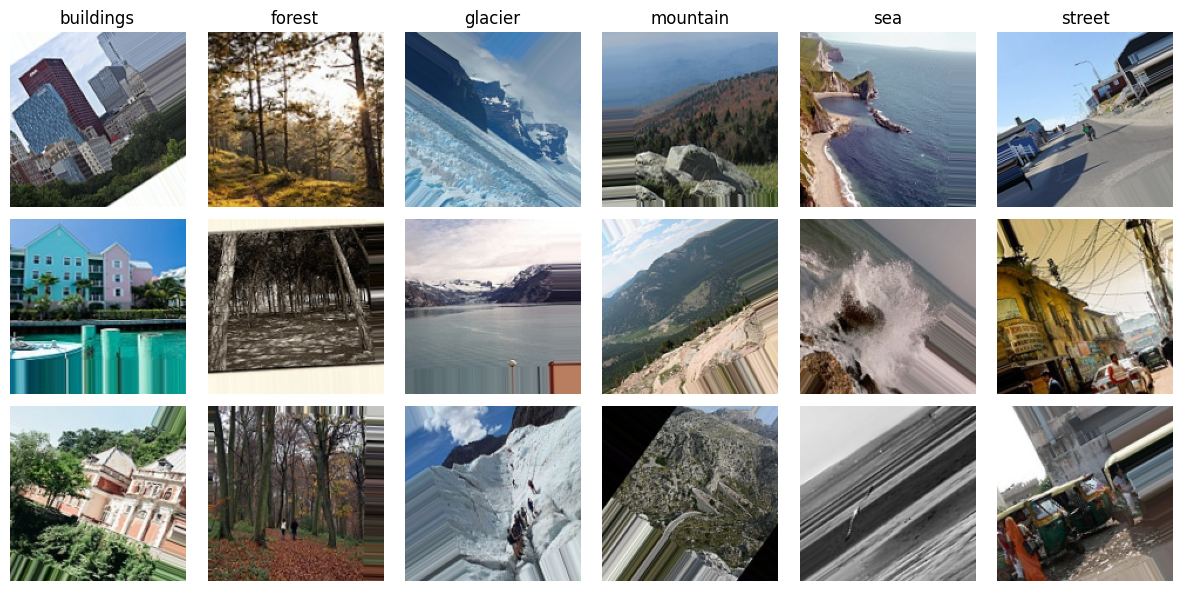

In [61]:
category_names = list(train_generator.class_indices.keys())
display_images_per_category(train_generator,category_names,images_per_category = 3)

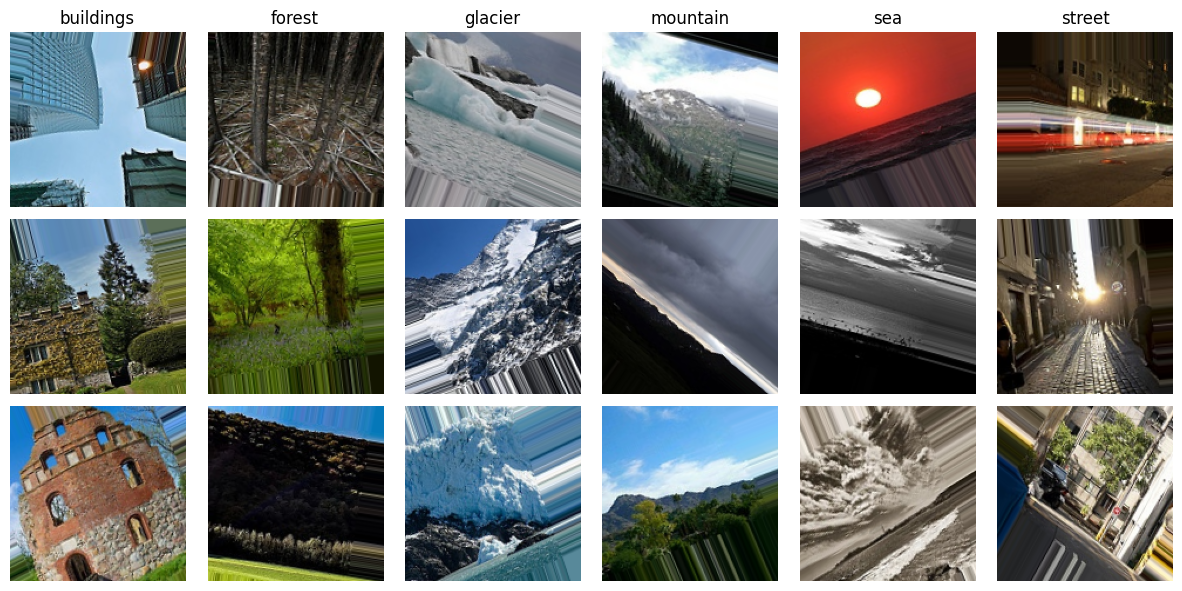

In [62]:
category_names = list(validation_generator.class_indices.keys())
display_images_per_category(validation_generator,category_names,images_per_category = 3)

In [63]:
input_shape = train_generator.image_shape
category_count = len(category_names)

In [64]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f" Learning Rate = {current_lr:.6f}")

In [65]:
epochs = 25
initial_learning_rate = 4e-4
end_learning_rate = 9e-5
decay_steps = math.ceil((train_generator.samples // batch_size) * 1)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=0.95)

lr_logger = LearningRateLogger()

# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
#     initial_learning_rate,
#     decay_steps,
#     end_learning_rate,
#     power=2.0)

adam = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

# Instantiate Resnet18

In [66]:
resnet18 = ResNet18(category_count)
inputs = tf.keras.Input(shape=input_shape)
resnet18(inputs)

<KerasTensor shape=(None, 6), dtype=float32, sparse=False, name=keras_tensor_109>

# Train Model

In [67]:
model = ModelWrapper(resnet18, batch_size)
model.compile(optimizer = adam)
model.summary()

Model: "res_net18_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_180 (Conv2D)             │ ?                      │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_180         │ ?                      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_72 (ResnetBlock)   │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_73 (ResnetBlock)   │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_74 (ResnetBlock)   │ ?                      │       231,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_75 (ResnetBlock)   │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_76 (ResnetBlock)   │ ?                      │       921,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_77 (ResnetBlock)   │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_78 (ResnetBlock)   │ ?                      │     3,677,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_79 (ResnetBlock)   │ ?                      │     4,723,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,193,990 (42.70 MB)

 Trainable params: 11,184,390 (42.67 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
history = model.train(train_generator, validation_generator, callbacks = [lr_logger], epochs = epochs, )

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.2988 - loss: 4.4886 Learning Rate = 0.000380
175/175 ━━━━━━━━━━━━━━━━━━━━ 110s 533ms/step - accuracy: 0.2994 - loss: 4.4745 - val_accuracy: 0.5051 - val_loss: 1.2032
Epoch 2/25
  1/175 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.4844 - loss: 1.2833 Learning Rate = 0.000380
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4844 - loss: 1.2833 - val_accuracy: 0.4231 - val_loss: 1.1770
Epoch 3/25
 38/175 ━━━━━━━━━━━━━━━━━━━━ 52s 380ms/step - accuracy: 0.5466 - loss: 1.1227

# Plotting Model Accuracy

In [ ]:
def plot_accuracy_values(history):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

In [ ]:
plot_accuracy_values(history)